In [1]:
import pandas as pd 
import numpy as np 
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

In [2]:
meteo_orly = pd.read_csv(os.path.join("..", "Datasets", "meteo_orly.csv"))
meteo_paris = pd.read_csv(os.path.join("..", "Datasets", "meteo_paris.csv"))

In [3]:
meteo_orly = meteo_orly[['date', 't', 'vv']] # Find out what vv is 
meteo_orly['t'] = (meteo_orly['t'] - 273.15)
meteo_orly['vv'] = meteo_orly['vv']/150
meteo_paris = meteo_paris[['datetime', 'precip']]


<Axes: xlabel='precip', ylabel='Count'>

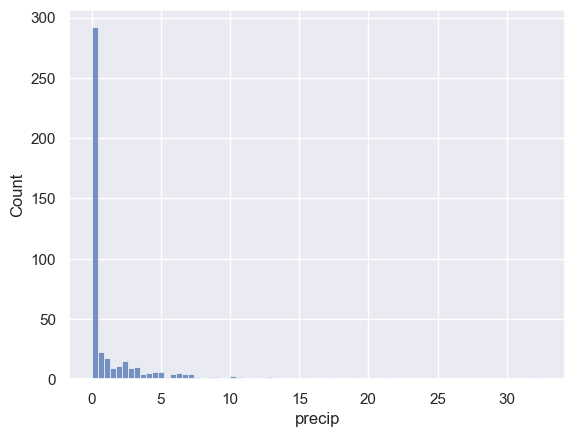

In [4]:
sns.histplot(data = meteo_paris, x = 'precip')

In [5]:
# Making 3 categories of precipitation 
# We ordinal encode them as there is some notion of ordering 
# Change categories as required

conditions = [
    (meteo_paris['precip'] == 0),
    ((meteo_paris['precip'] > 0) & (meteo_paris['precip'] < 2)),
    (meteo_paris['precip'] >= 2)
]
values = [1, 2, 3]

meteo_paris['precipitation_level'] = np.select(conditions, values, default=0)

meteo_paris.drop('precip', axis=1, inplace=True)

In [6]:

meteo_orly['date'] = pd.to_datetime(meteo_orly['date'])
meteo_orly['date_only'] = meteo_orly['date'].dt.date
meteo_paris['date_only'] = pd.to_datetime(meteo_paris['datetime']).dt.date


meteo = pd.merge(meteo_orly, meteo_paris, on='date_only', how='outer')

# Dump unnecessary columns

meteo.drop(['date_only', 'datetime'], axis=1, inplace=True)


In [7]:
meteo_orly.tail()

,date,t,vv,date_only
3317,2020-09-30 09:00:00,16.8,120.000000,2020-09-30
3318,2020-09-30 12:00:00,18.9,166.666667,2020-09-30
3319,2020-09-30 15:00:00,18.4,166.666667,2020-09-30
3320,2020-09-30 18:00:00,17.0,272.133333,2020-09-30
3321,2020-09-30 21:00:00,15.2,168.333333,2020-09-30


In [8]:
meteo.head()

# Note there is some NaNs in here as the date ranges dont really match up 

,date,t,vv,precipitation_level
0,2021-01-01 00:00:00,-0.4,6.600000,2
1,2021-01-01 03:00:00,-1.9,1.400000,2
2,2021-01-01 06:00:00,-1.2,24.400000,2
3,2021-01-01 09:00:00,-0.7,23.333333,2
4,2021-01-01 12:00:00,3.8,53.333333,2


In [9]:
#Classes are pretty balanced

print(meteo['precipitation_level'].value_counts())


precipitation_level
2    1430
1    1129
3     803
Name: count, dtype: int64


## Now we look at Covid-19 cases

# Finalizing the meteo dataset to export


In [10]:
meteo.rename(columns={'t': 'temperature_C'}, inplace=True)
meteo.dropna(inplace=True)
meteo.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3322 entries, 0 to 3321
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 3322 non-null   datetime64[ns]
 1   temperature_C        3322 non-null   float64       
 2   vv                   3322 non-null   float64       
 3   precipitation_level  3322 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(1)
memory usage: 116.8 KB


In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Extract the columns for scaling
columns_to_scale = ['temperature_C', 'vv']
data_to_scale = meteo[columns_to_scale]

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the selected columns and transform the data
scaled_data = scaler.fit_transform(data_to_scale)

# Replace the original columns with the scaled values
meteo[columns_to_scale] = scaled_data



In [15]:
meteo['date'] = pd.to_datetime(meteo['date'])
meteo['year'] = meteo['date'].dt.year
meteo['month'] = meteo['date'].dt.month
meteo['day'] = meteo['date'].dt.day
meteo['dateindex'] = meteo['month'].astype(str) + meteo['year'].astype(str) + meteo['day'].astype(str)
meteo.drop(columns='date', inplace=True)

KeyError: 'date'

In [13]:
meteo.head()

,temperature_C,vv,precipitation_level,year,month,day,dateindex
0,-1.916295,-1.862704,2,2021,1,1,202111
1,-2.135252,-1.938565,2,2021,1,1,202111
2,-2.033072,-1.603027,2,2021,1,1,202111
3,-1.960087,-1.618588,2,2021,1,1,202111
4,-1.303217,-1.180931,2,2021,1,1,202111


In [14]:
meteo.to_csv(os.path.join("..", "Datasets", "meteo_paris_clean.csv"), index=False)